In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel('neo 1.xlsx')
df.head()
#df = df [['job_uuid_after','weights_before','psgv_start_time','psgv_end_time','weights_after']]
df = df[['weights_before','psgv_start_time','psgv_end_time','weights_after']]
#df = df.loc[df['weights_before'] > df ['weights_after']]
df.head(20)

,weights_before,psgv_start_time,psgv_end_time,weights_after
0,0.38,0.0,0.0,0.38
1,0.20,1986.0,1988.0,0.77
2,0.17,2003.0,2005.0,0.00
3,0.00,2004.0,2008.0,0.00
4,0.00,1996.0,1998.0,0.00
5,0.77,1991.0,1993.0,0.77
6,0.90,0.0,0.0,0.90
7,0.00,1995.0,1998.0,0.00
8,0.00,1994.0,1997.0,0.00
9,0.60,2000.0,2003.0,0.00


In [3]:
# this is hard to legitimate the imputing we can sadly call them missing data and had to delete them
num_rows_with_zeros = (df[['psgv_start_time', 'psgv_end_time']] == 0).any(axis=1).sum()

num_rows_with_zeros

870

In [4]:
# Getting rid of unrelatd string column and using Imputer on target columns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Dynamic Imputing
zero_col_index_1 = df[df['weights_before'] == 0]['weights_before'].index
for i in zero_col_index_1:
    df['weights_before'][i] = np.nan

imp = IterativeImputer(random_state=7)
df.iloc[:, :] = imp.fit_transform(df.iloc[:, :])

zero_col_index_2 = df[df['weights_after'] == 0]['weights_after'].index
for i in zero_col_index_2:
    df['weights_after'][i] = np.nan

imp = IterativeImputer(random_state=7)
df.iloc[:, :] = imp.fit_transform(df.iloc[:, :])

In [5]:
df = df[df['psgv_start_time'] != 0]
df.head(20)


,weights_before,psgv_start_time,psgv_end_time,weights_after
1,0.200000,1986.000000,1988.000000,0.770000
2,0.170000,2003.000000,2005.000000,0.369341
3,0.506150,2004.000000,2008.000000,0.530645
4,0.505961,1996.000000,1998.000000,0.530748
5,0.770000,1991.000000,1993.000000,0.770000
7,0.505923,1995.000000,1998.000000,0.530740
8,0.505897,1994.000000,1997.000000,0.530748
9,0.600000,2000.000000,2003.000000,0.575789
10,0.655821,2000.000000,2004.000000,0.473191
11,0.770000,1992.000000,1996.000000,0.657546


In [6]:
from sklearn.preprocessing import RobustScaler

continuous_columns = ['psgv_start_time', 'psgv_end_time', 'weights_before', 'weights_after']

# Instantiate the scaler
scaler = RobustScaler()

df[continuous_columns] = scaler.fit_transform(df[continuous_columns])

In [7]:
df['target'] = (df['weights_after'] > df['weights_before']).astype(int)
df.head(20)
num = (df['weights_before'] == df['weights_after']).sum()
num

0

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#extract features
X = df.drop(['weights_after', 'target'], axis=1)

# extract labels
y = df['target']

(df['target'] == 1).sum()

2207

2207/3639 has been improved

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [11]:
y_pred = model.predict(X_test)

In [12]:
from sklearn.metrics import f1_score
print ('F1 =' ,f1_score(y_test, y_pred))

F1 = 0.7473684210526315


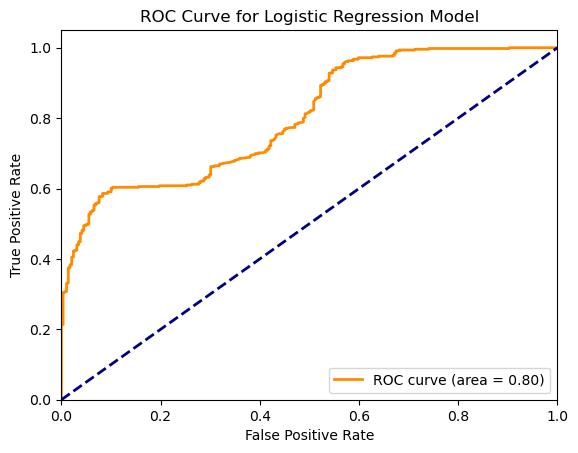

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
probs = model.predict_proba(X_test)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression Model')
plt.legend(loc="lower right")
plt.show()


In [14]:
# Print
print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')
print(f'Model parameters: {model.get_params()}')


Coefficients: [[-1.2550671   0.19611969 -0.00969806]]
Intercept: [0.52701871]
Model parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


For weights_before, the coefficient is approximately -1.233. This suggests that as weights_before increases by one unit, the log odds of the target variable being 1 decrease, which indicates that higher values of weights_before are associated with a lower likelihood of the target being 1.
For psgv_start_time, the coefficient is approximately 0.201. This indicates a positive relationship with the target variable, meaning that as psgv_start_time increases, the likelihood of the target being 1 increases.
For psgv_end_time, the coefficient is approximately -0.0089. This suggests a very small negative relationship with the target.

In [15]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[153 136]
 [104 355]]
